In [ ]:
pip install python-crfsuite nltk

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 9.7 MB/s eta 0:00:00


In [ ]:
import nltk
import pycrfsuite
from nltk.corpus import brown
from sklearn.model_selection import train_test_split

# Download Brown Corpus and Universal Tagset
nltk.download('brown')
nltk.download('universal_tagset')

# Load Brown sentences with the universal tagset
dataset = list(brown.tagged_sents(tagset='universal'))

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.


In [14]:
class FeatureExtractor:
    def __init__(self):
        pass

    def word2features(self, sent, i):
        #this function creates a features of the current word.
        word = sent[i][0]  #current word

        # Base features for the current word
        features = {
            'bias': 1.0,
            'word.lower()': word.lower(),
            'word[-3:]': word[-3:],  # Last 3 letters For suffixes
            'word[-2:]': word[-2:],  # Last 2 letters for suffixes
            'word[0:2]': word[0:2], # first 3 letters for prefixes
            'word.isupper()': word.isupper(),
            'word.istitle()': word.istitle(),
            'word.isdigit()': word.isdigit(),
        }

        # Features from the previous word
        if i > 0:
            word_prev = sent[i - 1][0]
            features.update({
                '-1:word.lower()': word_prev.lower(),
                '-1:word.istitle()': word_prev.istitle(),
                '-1:word.isupper()': word_prev.isupper(),
            })
        else:
            features['BOS'] = True  # Beginning of sentence

        # Features from the next word
        if i < len(sent) - 1:
            word_fwd = sent[i + 1][0]
            features.update({
                '+1:word.lower()': word_fwd.lower(),
                '+1:word.istitle()': word_fwd.istitle(),
                '+1:word.isupper()': word_fwd.isupper(),
            })
        else:
            features['EOS'] = True  # End of sentence

        return features

    def sent2features(self, sent):
        #this function creates a features of the sentence.
        feat = []
        for i in range(len(sent)):
            feat.append(self.word2features(sent, i))
        return feat

    def sent2labels(self, sent):
        #this function creates a labels of the sentence.
        labels = []
        for _,label in sent:
            labels.append(label)
        return labels

In [ ]:
from collections import defaultdict, Counter

def create_int_defaultdict():
    return defaultdict(int)

def create_float_defaultdict():
    return defaultdict(float)

In [30]:
from sklearn.metrics import precision_recall_fscore_support
import numpy as np
from sklearn.model_selection import KFold
import seaborn as sns
import matplotlib.pyplot as plt

class Evaluation:
    def __init__(self):
        self.accuracy = []
        self.confusion_matrix = defaultdict(create_int_defaultdict)
        self.accuracy_per_tag = defaultdict(list)

    def cross_validate(self, X, y, n=5):
        k_fold = KFold(n_splits=n, shuffle=True, random_state=26)
        for train_i, test_i in k_fold.split(X):
            X_train = [X[i] for i in train_i]
            y_train = [y[i] for i in train_i]
            X_test = [X[i] for i in test_i]
            y_test = [y[i] for i in test_i]
            trainer = pycrfsuite.Trainer(verbose=False)
            for xseq, yseq in zip(X_train, y_train):
                trainer.append(xseq, yseq)
            trainer.set_params({
                'c1': 10.0,
                'c2': 1e-2,
                'max_iterations': 100,
                'feature.possible_transitions': True
            })
            trainer.train('crf_pos_tagger_cv.model')

            # Load the trained model
            tagger = pycrfsuite.Tagger()
            tagger.open('crf_pos_tagger_cv.model')
            y_pred = [tagger.tag(xseq) for xseq in X_test]

            correct_tagged = 0
            total = 0
            for sent_true, sent_pred in zip(y_test, y_pred):
                for correct_tag, predicted_tag in zip(sent_true, sent_pred):
                    if correct_tag == predicted_tag:
                        correct_tagged += 1
                    self.confusion_matrix[correct_tag][predicted_tag] += 1
                    self.accuracy_per_tag[correct_tag].append(correct_tag == predicted_tag)
                    total += 1
            self.accuracy.append(correct_tagged / total)
        return np.mean(self.accuracy)

    def test_eval(self, data, model):
        correct_tagged = 0
        total = 0
        for i in data:
            words = [word for word, tag in i]
            correct_tags = [tag for word, tag in i]
            predicted_tags = model.predict(words)
            for correct_tag, predicted_tag in zip(correct_tags, predicted_tags):
                if correct_tag == predicted_tag:
                    correct_tagged += 1
                self.confusion_matrix[correct_tag][predicted_tag] += 1
                self.accuracy_per_tag[correct_tag].append(correct_tag == predicted_tag)
                total += 1
            self.accuracy.append(correct_tagged/total)

        return np.mean(self.accuracy)

    def plot_eval(self):
        tags = sorted(self.confusion_matrix.keys())
        matrix = np.array([[self.confusion_matrix[true_tag][predicted_tag] for predicted_tag in tags] for true_tag in tags])

        plt.figure(figsize=(10, 8))
        sns.heatmap(matrix, annot=True, fmt="d", xticklabels=tags, yticklabels=tags)
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.title("Confusion Matrix")
        plt.show()
        plt.savefig("confusion_matrix_plot.png")

        tag_accuracies = {tag: np.mean(accuracies) for tag, accuracies in self.accuracy_per_tag.items()}

        for tag, accuracy in tag_accuracies.items():
            print(f"Accuracy for {tag}: {accuracy:.2f}")

        return tag_accuracies

    def compute_f1(self):
        tags = sorted(self.confusion_matrix.keys())
        # Extracting true labels and predicted labels
        y_true, y_pred = [], []
        for true_tag in tags:
            for predicted_tag in tags:
                count = self.confusion_matrix[true_tag][predicted_tag]
                y_true.extend([true_tag] * count)
                y_pred.extend([predicted_tag] * count)

        # Calculating precision, recall, f1 score
        precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, labels=tags, average='macro')

        print(f"Precision: {precision:.2f}")
        print(f"Recall: {recall:.2f}")
        print(f"F1 Score: {f1:.2f}")

        return precision, recall, f1

    def compute_per_tag_metrics(self):
        tags = sorted(self.confusion_matrix.keys())
        metrics = {}

        for tag in tags:
            tp = self.confusion_matrix[tag][tag]
            fn = sum(self.confusion_matrix[tag][predicted_tag] for predicted_tag in tags if predicted_tag != tag)
            fp = sum(self.confusion_matrix[true_tag][tag] for true_tag in tags if true_tag != tag)

            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

            metrics[tag] = {
                "precision": precision,
                "recall": recall,
                "f1_score": f1
            }

        return metrics

In [26]:
feature_extractor = FeatureExtractor()
X = [feature_extractor.sent2features(s) for s in dataset]
y = [feature_extractor.sent2labels(s) for s in dataset]

In [32]:
eval = Evaluation()
eval.cross_validate(X,y)

0.9623306196372781

In [34]:
precision, recall, f1 = eval.compute_f1()

Precision: 0.93
Recall: 0.90
F1 Score: 0.91


In [35]:
def fscore(p, r, beta):
    return p*r*(1 + beta*beta)/(beta*beta*p + r)

for i in [0.5, 1, 2]:
    print(f"Overall f{i}-score: {fscore(precision, recall, i)}")

Overall f0.5-score: 0.9226337948955791
Overall f1-score: 0.9123086242094882
Overall f2-score: 0.9022119933705504


In [36]:
per_pos = eval.compute_per_tag_metrics()
for pos in per_pos.keys():
    print(pos)
    print(f"P: {per_pos[pos]['precision']:.3f}, R: {per_pos[pos]['recall']:.3f}, F1: {per_pos[pos]['f1_score']:.3f}")

.
P: 1.000, R: 1.000, F1: 1.000
ADJ
P: 0.899, R: 0.856, F1: 0.877
ADP
P: 0.974, R: 0.975, F1: 0.974
ADV
P: 0.934, R: 0.910, F1: 0.922
CONJ
P: 0.993, R: 0.996, F1: 0.995
DET
P: 0.992, R: 0.994, F1: 0.993
NOUN
P: 0.943, R: 0.964, F1: 0.953
NUM
P: 0.968, R: 0.942, F1: 0.955
PRON
P: 0.990, R: 0.984, F1: 0.987
PRT
P: 0.922, R: 0.928, F1: 0.925
VERB
P: 0.961, R: 0.961, F1: 0.961
X
P: 0.581, R: 0.237, F1: 0.337


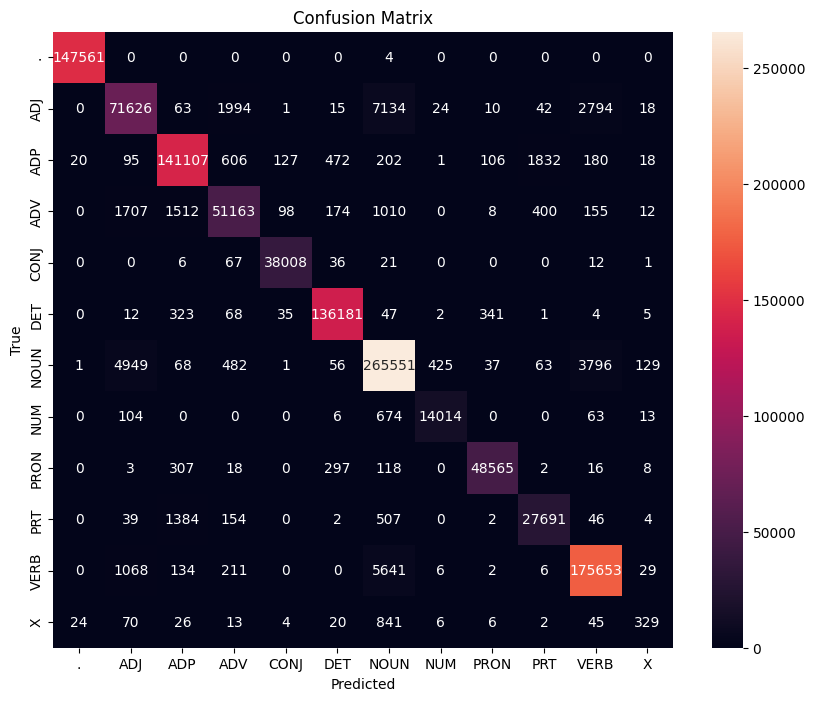

Accuracy for DET: 0.99
Accuracy for NOUN: 0.96
Accuracy for VERB: 0.96
Accuracy for PRON: 0.98
Accuracy for ADP: 0.97
Accuracy for ADJ: 0.86
Accuracy for CONJ: 1.00
Accuracy for .: 1.00
Accuracy for ADV: 0.91
Accuracy for NUM: 0.94
Accuracy for PRT: 0.93
Accuracy for X: 0.24


{'DET': 0.9938840598749079,
 'NOUN': 0.9636845963463228,
 'VERB': 0.9611655266757866,
 'PRON': 0.9844123728057729,
 'ADP': 0.9747247281820317,
 'ADJ': 0.8555320648343904,
 'CONJ': 0.9962517365206679,
 '.': 0.999972893301257,
 'ADV': 0.9097423496150359,
 'NUM': 0.9421809869571064,
 'PRT': 0.9283247846055852,
 'X': 0.23737373737373738}

<Figure size 640x480 with 0 Axes>

In [33]:
eval.plot_eval()